# CPSC 330 Lecture 5

#### Lecture outline

- Announcements
- Left over from last class: `C` hyperparameter in `LogisticRegression` (10 min)
- Scaling/normalizing continuous features (20 min)
- One-hot encoding categorical features (25 min)
- Break (5 min)
- Another classifier: SVMs (10 min)
- Another classifier: random forests (15 min)

Piazza:
- Random Forest True/False

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs
from sklearn.compose import ColumnTransformer

from plot_classifier import plot_classifier

## Announcements

- Thanks to those who have filled out the survey on Canvas! 
  - Please fill out the survey if you haven't already.
- Per student feedback, the midterm on Feb 13 will start 11:05 and run for 75 minutes. 
- hw3 due Sunday at 6pm
- Extra office hour on Friday at 9am (Nam) 
  - This time slot might become permanent, see calendar.
- I have to run off after class - please post questions on Piazza.

High level note: 

- This is the first time I'm offering CPSC 330. 
- I'm not sure yet what is a good level of depth
  - Am I sweeping too much under the rug? I want you to have some basic understanding of what is going on.
  - But I don't want this to be another CPSC 340. I need the extra time to do new things.
- Please feel free to give me feedback on this issue throughout the course. 


In [3]:
def show_scores(model, 
                X_train, y_train,
                X_valid, y_valid):
    """
    Shows train and test error 
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_valid: numpy.ndarray        
        The X part of the validation set
    y_valid: numpy.ndarray
        The y part of the validation set    
    Returns
    -------
        None
        prints the train and validation errors. 
    
    Usage: show_scores(lr, X_train, y_train, X_test, y_test)
    
    """    
#     print('Model: ', model)
    print("Training error: %.3f" % (1-model.score(X_train, y_train)))
    print("Test     error: %.3f" % (1-model.score(X_valid, y_valid)))
#     print('\n\n')

## Feature normalization/standardization (15 mins)

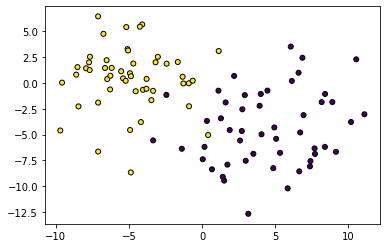

In [4]:
n_classes = 2
X, y = make_blobs(n_features=2, centers=2, cluster_std=3, random_state=123)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k');

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.5,
                                                    random_state=123)

In [6]:
lr = LogisticRegression()
lr.fit(X_train, y_train);

/Users/mgelbart/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
show_scores(lr, X_train, y_train, X_test, y_test)

Training error: 0.060
Test     error: 0.020


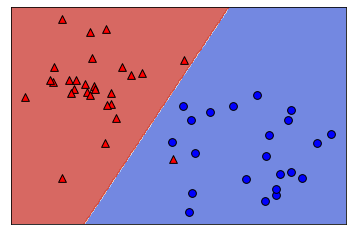

In [8]:
plot_classifier(X_test, y_test, lr);

- What happens if we scale the first feature by 1/1000?
- You could imagine these being distances, and now we've collected one of them in kilometres instead of metres.
  - Intuitively, this should not affect the predictive power of our model.

In [9]:
X_train2 = X_train.copy()
X_train2[:,0] /= 1000
X_test2 = X_test.copy()
X_test2[:,0] /= 1000

In [10]:
X_train2[:10]

array([[ 1.67741709e-04, -6.19046781e+00],
       [-7.73228256e-03,  1.99135511e+00],
       [ 6.75679976e-04, -8.36762793e+00],
       [-7.10973217e-03, -1.90787774e+00],
       [ 1.05471740e-02,  2.28314497e+00],
       [-1.33119848e-03,  5.96767459e-01],
       [ 4.87219970e-03, -8.25600968e+00],
       [-4.87191413e-03, -8.66686964e+00],
       [ 3.93792146e-03, -2.21254517e+00],
       [-4.54081827e-03, -8.07380639e-01]])

In [11]:
lr2 = LogisticRegression()
lr2.fit(X_train2, y_train);

/Users/mgelbart/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
show_scores(lr2, X_train2, y_train, X_test2, y_test)

Training error: 0.260
Test     error: 0.180


- Note that the test error went up from 2% to 18%!!
- Decision trees don't have this problem:

In [13]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)
show_scores(dt, X_train, y_train, X_test, y_test)

Training error: 0.000
Test     error: 0.040


In [14]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train2, y_train)
show_scores(dt, X_train2, y_train, X_test2, y_test)

Training error: 0.000
Test     error: 0.040


- Hmm, this does worse. What is happening?
- Answer: `LogisticRegression` is sensitive to the scaling of the features (especially for small `C`).
  - There is an implicit assumption that the different features are on a "level playing field".
  - Which means if one of them has really small values, it's not being considered much.

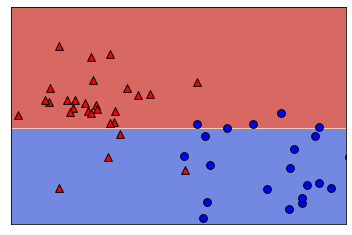

In [15]:
plot_classifier(X_test2, y_test, lr2, lims=(-.01, .01, -10, 10));

- It seems the model is just predicting a horizontal line!
- It is worrying that we get such a bad result.

- This problem affects a large number of ML methods.
- Two approaches to this problem are standardization and normalization


| Approach | What it does | How to update $X$ (but see below!) | sklearn implementation | 
|---------|------------|-----------------------|----------------|
| normalization | sets range to $[0,1]$   | `X -= np.min(X,axis=0)`<br>`X /= np.max(X,axis=0)`  | [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
| standardization | sets sample mean to $0$, s.d. to $1$   | `X -= np.mean(X,axis=0)`<br>`X /=  np.std(X,axis=0)` | [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) |

There are all sorts of articles on this; see, e.g. [here](http://www.dataminingblog.com/standardization-vs-normalization/) and [here](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc).

- Let's see a quick example of using these scaling methods

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [17]:
scaler = StandardScaler()
scaler.fit(X_train2)
X_train2_scaled = scaler.transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

- Note the same Golden Rule issue we talked about last class!!
- We fit the transformer on the training data, and then transform both data sets.

Let's check that it did what we expected:

In [18]:
X_train2_scaled.mean(axis=0)

array([3.10862447e-17, 7.77156117e-17])

In [122]:
X_train2_scaled.std(axis=0)

array([1., 1.])

Note that for test we get something different - that is OK!!

In [123]:
X_test2_scaled.mean(axis=0)

array([0.00499913, 0.24599373])

In [124]:
X_test2_scaled.std(axis=0)

array([1.15537989, 0.92337763])

In [125]:
lr3 = LogisticRegression()
lr3.fit(X_train2_scaled, y_train);

In [126]:
show_scores(lr3, X_train2_scaled, y_train, X_test2_scaled, y_test)

Training error: 0.080
Test     error: 0.020


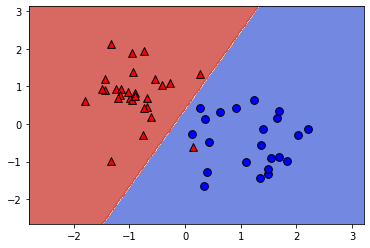

In [127]:
plot_classifier(X_test2_scaled, y_test, lr3, ticks=True);

Here we got back something reasonable.

In [131]:
minmax = MinMaxScaler()
minmax.fit(X_train2)
X_train2_minmax = minmax.transform(X_train2)
X_test2_minmax  = minmax.transform(X_test2)

Let's again check the results:

In [132]:
X_train2_minmax.min(axis=0)

array([0., 0.])

In [133]:
X_train2_minmax.max(axis=0)

array([1., 1.])

And again for test:

In [137]:
X_test2_minmax.min(axis=0)

array([0.0060665 , 0.17735288])

In [138]:
X_test2_minmax.max(axis=0)

array([1.02762574, 1.05531983])

In [139]:
lr4 = LogisticRegression()
lr4.fit(X_train2_minmax, y_train);

In [140]:
show_scores(lr4, X_train2_minmax, y_train, X_test2_minmax, y_test)

Training error: 0.080
Test     error: 0.040


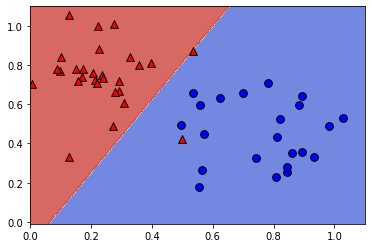

In [141]:
plot_classifier(X_test2_minmax, y_test, lr4, ticks=True, lims=(0, 1.1, -0.01, 1.1));

And, again, something reasonable.

In general, I would guess standardization is more popular, but you see normalization too.

#### Preprocessing the targets?

- Generally not needed, but we sometimes do.
- More on this below, with one-hot encoding.

## Encoding of categorical variables (25 mins)

- In scikit-learn, most algorithms require numeric inputs.
- That means we have to convert categorical features to numeric values.
- We will do this twice: with a toy dataset for illustration, and then with a bigger dataset to compute scores.

- First dataset: we are looking at the `effect` of different treatment for depression.
- We would like to use `age`, `weight`, and `treatment` to predict `effect`.

In [90]:
df = pd.read_csv('data/depression_data.csv')
df.head()

,age,weight,treatment,effect
0,21,57.8,A,56
1,23,60.3,B,41
2,30,60.5,B,40
3,19,38.7,C,28
4,28,96.5,A,55


In [91]:
X = df[['age', 'weight', 'treatment']]
y = df['effect'] 

- Let's try to build a `LogisticRegression` classifier on this data?
- This will fail because we have non-numeric data.

In [92]:
lr = LogisticRegression()
lr.fit(X, y)

/Users/mgelbart/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: 'C'

#### No encoding (not recommended!)

- For starters, let's just delete the categorical feature.

In [93]:
X_drop = X.drop(columns=["treatment"])
X_drop.head()

,age,weight
0,21,57.8
1,23,60.3
2,30,60.5
3,19,38.7
4,28,96.5


#### Ordinal encoding (occasionally recommended)

- Here we simply assign an integer to each of our unique categorical labels
- We can use sklearn's [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [95]:
from sklearn.preprocessing import OrdinalEncoder

In [108]:
oe = OrdinalEncoder(dtype='int')
oe.fit(X[['treatment']])

X_ord = X.copy()
X_ord['treatment_encoded'] = oe.transform(X[['treatment']])
X_ord.head()

,age,weight,treatment,treatment_encoded
0,21,57.8,A,0
1,23,60.3,B,1
2,30,60.5,B,1
3,19,38.7,C,2
4,28,96.5,A,0


In [109]:
X_ord = X_ord.drop(columns='treatment')
X_ord.head()

,age,weight,treatment_encoded
0,21,57.8,0
1,23,60.3,1
2,30,60.5,1
3,19,38.7,2
4,28,96.5,0


- Can you see a big problem with this approach?
  - We have imposed ordinality on the categorical data.
  - For example, Treatment C (3) is "closer" to Treatment B (2) than Treatment A (1)
  - In general, label encoding is useful if there is ordinality in your data, e.g., `[cold, warm, hot]`.

#### One-hot encoding (OHE)
- Rather than assign integer labels to our data, we use create new binary columns to represent our categories.
- If we have $c$ categories in our column.
- We create $c$ new binary columns to represent those categories.
- We can use sklearn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [110]:
from sklearn.preprocessing import OneHotEncoder

In [111]:
ohe = OneHotEncoder(sparse=False, dtype='int')

In [112]:
ohe.fit(X[['treatment']])

X_ohe = pd.concat((X, pd.DataFrame(ohe.transform(X[['treatment']]),
                           columns=ohe.categories_[0], index=X.index)), axis=1)
X_ohe.head()

,age,weight,treatment,A,B,C
0,21,57.8,A,1,0,0
1,23,60.3,B,0,1,0
2,30,60.5,B,0,1,0
3,19,38.7,C,0,0,1
4,28,96.5,A,1,0,0


- We put a "1" for the actual value and "0" otherwise.
- But in fact, do we need all 3 columns?
  - After all, if `B` is 0 and `C` is 0, then `A` must be 1, right?
  - So, we drop one of the columns (usually the first one by convention).
- We can specify this in `OneHotEncoder()` by using the argument `drop='first'`

In [117]:
ohe = OneHotEncoder(drop='first', sparse=False, dtype='int')

ohe.fit(X[['treatment']])

X_ohe = pd.concat((X, pd.DataFrame(ohe.transform(X[['treatment']]),
                           columns=ohe.categories_[0][1:], index=X.index)), axis=1)
X_ohe.head()

,age,weight,treatment,B,C
0,21,57.8,A,0,0
1,23,60.3,B,1,0
2,30,60.5,B,1,0
3,19,38.7,C,0,1
4,28,96.5,A,0,0


In [118]:
X_ohe = X_ohe.drop(columns='treatment')
X_ohe.head()

,age,weight,B,C
0,21,57.8,0,0
1,23,60.3,1,0
2,30,60.5,1,0
3,19,38.7,0,1
4,28,96.5,0,0


- Can we do better? What about our discussion of scaling from earlier?
- Our features are not on the same scale and our encodings are getting "drowned out" by `age` and `weight`.
- We should preprocess both numeric features (e.g., scaling) and categorical features (e.g., OHE).
- sklearn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) makes this more manageable.
  - A big advantage here is that we build all our transformations together into one object, and that way we're sure we do the same operations to all splits of the data. 
  - Otherwise we might, for example, do the OHE on both train and test but forget to scale the test data.

In [119]:
from sklearn.compose import ColumnTransformer

In [120]:
# Identify the categorical and numeric columns
numeric_features = ['age', 'weight']
categorical_features = ['treatment']

In [122]:
transformers=[
    ('scale', StandardScaler(), numeric_features),
    ('ohe', OneHotEncoder(drop='first'), categorical_features)]

In [123]:
# Create the transformer
preprocessor = ColumnTransformer(transformers=transformers)

When we fit the preprocessor, it fits _all_ the transformers.

In [125]:
preprocessor.fit(X);

We can get the new names of the columns that were generated by the one-hot encoding:

In [126]:
preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features)

array(['treatment_B', 'treatment_C'], dtype=object)

Combining this with the numeric feature names gives us all the column names:

In [127]:
columns = numeric_features + list(preprocessor.named_transformers_['ohe']
                                     .get_feature_names(categorical_features))
columns

['age', 'weight', 'treatment_B', 'treatment_C']

Like fit, when we transform with the preprocessor, it calls `transform` on _all_ the transformers.

In [129]:
# Apply data transformations and convert back to dataframe
X_ohe_scale = pd.DataFrame(preprocessor.transform(X),
                       index=X.index,
                       columns=columns)

In [130]:
X_ohe_scale.head()

,age,weight,treatment_B,treatment_C
0,-1.602301,-1.294360,0.0,0.0
1,-1.463640,-1.204307,1.0,0.0
2,-0.978328,-1.197103,1.0,0.0
3,-1.740961,-1.982364,0.0,1.0
4,-1.116989,0.099659,0.0,0.0


- Side note: the `ColumnTransformer` will automatically remove columns that are not being transformed:

In [132]:
preprocessor = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first'), categorical_features)])

preprocessor.fit_transform(X)

array([[0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 1.]])

Using `remainder='passthrough'` keeps the other columns in tact:

In [133]:
preprocessor = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first'), categorical_features)], 
                                 remainder='passthrough')

preprocessor.fit_transform(X)

array([[  0. ,   0. ,  21. ,  57.8],
       [  1. ,   0. ,  23. ,  60.3],
       [  1. ,   0. ,  30. ,  60.5],
       [  0. ,   1. ,  19. ,  38.7],
       [  0. ,   0. ,  28. ,  96.5],
       [  0. ,   1. ,  23. ,  41.8],
       [  1. ,   0. ,  33. , 111. ],
       [  0. ,   1. ,  67. , 158. ],
       [  1. ,   0. ,  42. , 109.4],
       [  0. ,   0. ,  33. ,  66.5],
       [  0. ,   0. ,  33. , 111.4],
       [  0. ,   1. ,  56. , 114.7],
       [  0. ,   1. ,  45. ,  91.6],
       [  1. ,   0. ,  43. ,  89.8],
       [  0. ,   0. ,  38. , 102.4],
       [  0. ,   1. ,  37. ,  75.7],
       [  1. ,   0. ,  43. ,  87.4],
       [  0. ,   1. ,  27. ,  49.9],
       [  0. ,   0. ,  43. ,  94.2],
       [  1. ,   0. ,  45. , 132. ],
       [  1. ,   0. ,  48. , 113.5],
       [  0. ,   1. ,  47. , 136. ],
       [  0. ,   0. ,  48. ,  95.3],
       [  0. ,   0. ,  53. , 121.6],
       [  1. ,   0. ,  58. , 121.1],
       [  0. ,   1. ,  29. ,  89.2],
       [  0. ,   0. ,  53. , 107.3],
 

#### Categorical labels

- For now sklearn is fine with categorical labels ($y$-values), so we're not preprocessing them.


#### Side note: 

- Theoretically, decision trees should have no problem with categorical inputs
  - e.g., "is the treatment equal to C?"
  - However, the sklearn implementation does not support this, so we need to convert the features to numerical.
- On the other hand, logistic regression fundamentally operates on numerical data
  - So any implementation would require these transformations.

## Break (5 min)

## Support Vector Machines (10 min)

#### SVM motivation: Which decision boundary is better? 

Let's generate some fake data with 2 features and 2 classes.

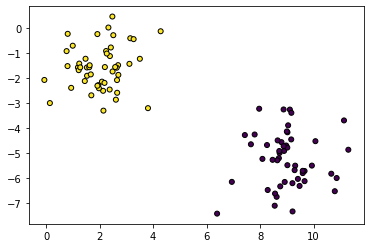

In [146]:
n_classes = 2
X_lin_sep, y_lin_sep = make_blobs(n_features=2, centers=n_classes, random_state=200)

plt.scatter(X_lin_sep[:, 0], X_lin_sep[:, 1], marker='o', c=y_lin_sep, s=25, edgecolor='k');

Which decision boundary is the best?

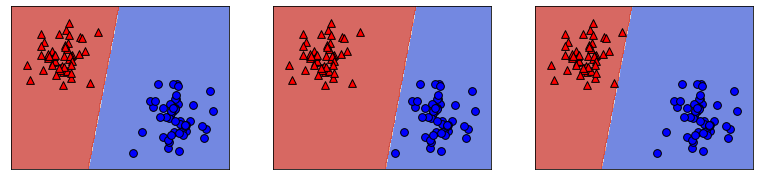

In [147]:
lr = LogisticRegression()
lr.fit(X_lin_sep, y_lin_sep);
intercepts = [lr.intercept_, lr.intercept_ + 1.6, lr.intercept_ -0.5]
plt.figure(figsize=(18,3))
for i in range(3):
    plt.subplot(1,4,i+1)
    lr.intercept_ = intercepts[i]
    plot_classifier(X_lin_sep,y_lin_sep,lr,ax=plt.gca())

#### SVMs: General idea

- Choose the hyperplane which is furthest away from the closest training points. 
- In other words, choose the hyperplane which has the largest **margin**, where margin is the distance from the boundary to the nearest point(s).
- Intuitively, more margin is good because it leaves more "room" before we make an error.

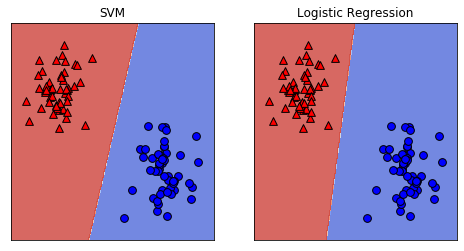

In [148]:
# Let's train an SVM classifier. 
# It picks the hyperplane than maximizes the margin. 
# Seems like logistic regression isn't doing it. 

svm = SVC(kernel="linear", C=1e6) # ignore the C=1e6 for now
svm.fit(X_lin_sep, y_lin_sep)

lr = LogisticRegression()
lr.fit(X_lin_sep, y_lin_sep);

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("SVM")
plot_classifier(X_lin_sep, y_lin_sep, svm, ax=plt.gca());
plt.subplot(1,2,2)
plt.title("Logistic Regression");
plot_classifier(X_lin_sep, y_lin_sep, lr, ax=plt.gca());

#### Support vectors 

- Each training example either is or isn't a "support vector".
  - This gets decided during `fit`.
  - It does not apply to test examples.
- Main idea: the decision boundary only depends on the support vectors.
- Let's look at the support vectors 

In [149]:
# generate blobs with fixed random generator
n = 20
n_classes = 2
X, y = make_blobs(n_samples=n, centers=n_classes, random_state=300)

In [150]:
# Let's train an SVM classifier
svm = SVC(kernel="linear", C=1e6)
svm.fit(X,y)

# How do we access support vectors
sv = svm.support_
not_sv = list(set(range(n)) - set(sv))
print('Support vectors: ', sv)
print('Non support vectors: ', not_sv)

Support vectors:  [ 3  8 14 19  0  1  6 17]
Non support vectors:  [2, 4, 5, 7, 9, 10, 11, 12, 13, 15, 16, 18]


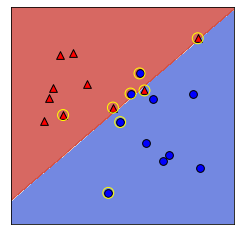

In [151]:
plt.figure(figsize=(4,4))
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

# The support vectors (SVs) are shown in yellow.
# These are the example that "support" the boundary. 

#### Support vectors

- Note that the number of support vectors is much smaller compared to the training set. 
- What happens if we delete all non-support vector? Would the decision boundary change? 
- What happens if we delete a support vector? Would the decision boundary change? 

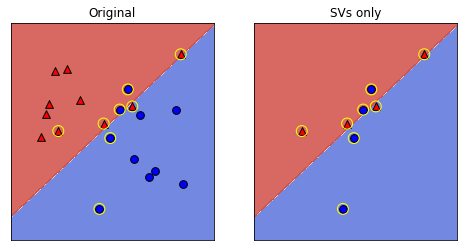

In [152]:
# Let's try removing all other examples, keeping only the SVs.
# remove all non-support vectors
X_only_SVs = np.delete(X,not_sv,0)
y_only_SVs = np.delete(y,not_sv,0)

svm_only_SVs = SVC(kernel="linear", C=1e6)
svm_only_SVs.fit(X_only_SVs, y_only_SVs)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.title("Original");
plt.subplot(1,2,2)
plot_classifier(X_only_SVs, y_only_SVs, svm_only_SVs, ax=plt.gca(), 
                lims=(X[:,0].min()-1,X[:,0].max()+1,X[:,1].min()-1,X[:,1].max()+1))
plt.scatter(*svm_only_SVs.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.title("SVs only");


### Nonlinear SVM (5 min)

- So far, logistic regression and SVMs are **linear classifiers**.
- However, they can be extended to nonlinear decision boundaries using "kernels".
- By default, `SVC` uses the "RBF kernel".
- It's also possible to do kernel logistic regression, but:
  - it's less popular than kernel SVM for computational reasons.
  - it's not implemented in scikit-learn.
  - why? because the code would be slower with logistic regression

In [153]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df['vote']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.5,
                                                    random_state=123)

In [154]:
linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train, y_train)
show_scores(linear_svm, X_train, y_train, X_test, y_test)

Training error: 0.240
Test     error: 0.240


In [155]:
# By dedault SVC uses rbf kernel 
rbf_svm = SVC()
rbf_svm.fit(X_train, y_train)
show_scores(rbf_svm, X_train, y_train, X_test, y_test)

Training error: 0.015
Test     error: 0.080


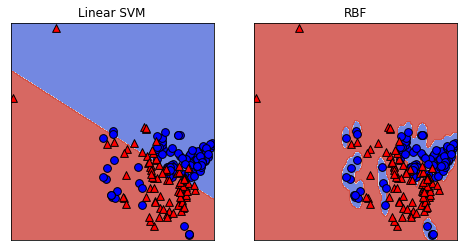

In [156]:
# Plot linear SVM
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_classifier(X_train, y_train, linear_svm, ax=plt.gca())
plt.title("Linear SVM");

# Plot RBF SVM
plt.subplot(1,2,2)
plot_classifier(X_train, y_train, rbf_svm, ax=plt.gca())
plt.title("RBF");

<Figure size 288x288 with 0 Axes>

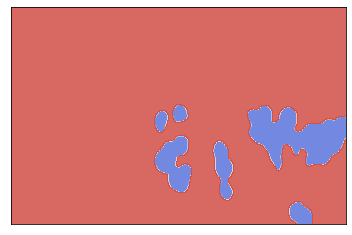

In [157]:
plt.figure(figsize=(4,4));
plot_classifier(X_train, y_train, rbf_svm, show_data=False);

## Hyperparameters

- Key Hyperparameters of `rbf` SVM are
    - `gamma`
    - `C`

See [`scikit-learn`'s explanation of RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). 

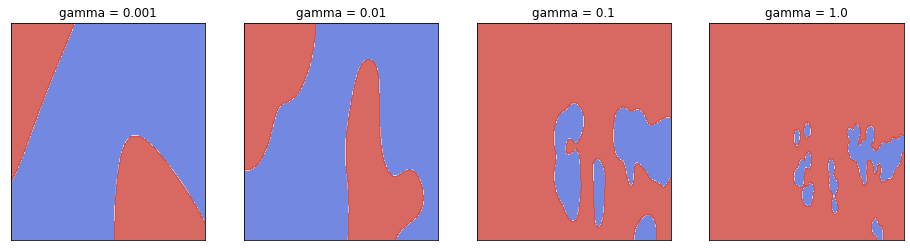

In [158]:
# What's the effect of the gamma parameter? 
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    gamma = 10.0**(i-3)
    rbf_svm = SVC(gamma=gamma)
    rbf_svm.fit(X_train, y_train);
    plot_classifier(X_train, y_train, rbf_svm, ax=plt.gca(), show_data=False);
    plt.title("gamma = %s"%gamma);

### Relation of gamma and the fundamental trade-off

- `gamma` controls the complexity (fundamental trade-off), just like other hyperparameters we've seen.
  - larger `gamma` $\rightarrow$ more complex
- `C` _also_ affects the fundamental tradeoff, although in a less intuitive way.
  - larger `C` $\rightarrow$ more complex  

## Random Forests (15 min)

- General idea
    - `fit` a diverse set of decision tree classifiers by **injecting randomness** in the classifier construction
    - `predict` by taking the average of predictions given by individual classifiers

- How do we inject randomness in the classifier construction? 
    1. Data: Build each tree on a bootstrap sample (i.e., a sample drawn **with replacement** from the training set)
    2. Features: 
        - Consider a random subset of features at each split (`RandomForestClassifier`)


#### The random forests classifier 

- Create a collection (ensemble) of trees. Grow each tree on an independent bootstrap sample from the data.
- At each node:
    - Randomly select a subset of features out of all features (independently for each node).
    - Find the best split on the selected features. 
    - Grow the trees to maximum depth.
    - Vote the trees to get predictions for new data. 

In [159]:
# Read IMDB movie reviews into a pandas DataFrame
imdb_df = pd.read_csv('data/imdb_master.csv', encoding = "ISO-8859-1")
# Only keep the reviews with pos and neg labels
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [160]:
# For converting words into frequency counts
from sklearn.feature_extraction.text import CountVectorizer
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(imdb_df['review'], 
                                                                        imdb_df['label'], 
                                                                        test_size = 0.20, 
                                                                        random_state = 12)

vec = CountVectorizer(max_features=5000,                       
                      stop_words='english')

# "fit" and transform the vectorizer on the training data*
X_train_counts = vec.fit_transform(X_train_imdb) 

# Only transform on the test data.  
X_test_counts = vec.transform(X_test_imdb) 

In [161]:
%%time
dt = tree.DecisionTreeClassifier(max_depth=20)
dt.fit(X_train_counts, y_train_imdb)
show_scores(dt, X_train_counts, y_train_imdb, X_test_counts, y_test_imdb) 

Training error: 0.169
Test     error: 0.259
CPU times: user 13.9 s, sys: 91.4 ms, total: 14 s
Wall time: 13.8 s


In [162]:
import graphviz

# define a function to plot our model
def save_and_show_decision_tree(model, 
                                class_names,
                                feature_names,
                                save_file_prefix = 'test'):
    """
    Saves the decision tree model as a pdf and shows how the data is split and 
    classified

    Parameters
    ----------
    model: sklearn.tree.DecisionTreeClassifier
        The sklearn model decision tree
    class_names : list
        The names of all the possible classifications
    feature_names : list
        The names of all the features
    save_file_prefix: str
        The name you wish to save the file

    Returns
    -------
    graphviz.files.Source
        The decision tree graph
    """
    dot_data = tree.export_graphviz(model, out_file=None, 
                             feature_names=feature_names,  
                             class_names=class_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  

    graph = graphviz.Source(dot_data) 
    graph.render(save_file_prefix) 
    return graph

In [163]:
vocab = vec.get_feature_names()
graph = save_and_show_decision_tree(dt, feature_names = vocab, class_names = ['neg','pos'])
# graph

In [164]:
%%time
# Estimators with max_depth 2 for illustration purposes. 
# Usually it's better to have higher depth.  
rf = RandomForestClassifier(n_estimators = 100, max_depth = 2)
rf.fit(X_train_counts, y_train_imdb)
show_scores(rf,X_train_counts, y_train_imdb, X_test_counts, y_test_imdb) 

Training error: 0.210
Test     error: 0.212
CPU times: user 3.57 s, sys: 107 ms, total: 3.67 s
Wall time: 3.31 s


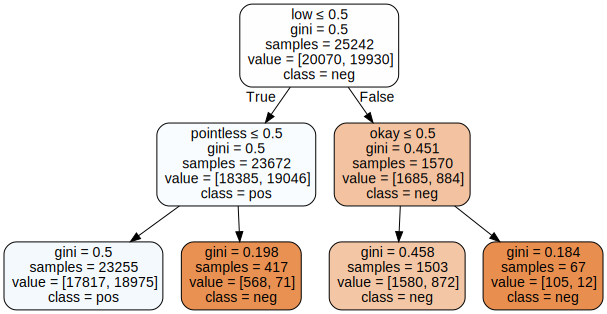

In [165]:
# Let's look at one of the estimators 
estimator = rf.estimators_[22]
graph = save_and_show_decision_tree(estimator, feature_names = vocab, class_names = ['neg','pos'])
graph

In [166]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df['vote']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.5,
                                                    random_state=123)


#### Random forests: number of trees and the fundamental tradeoff 

In [167]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df['vote']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.5,
                                                    random_state=123)

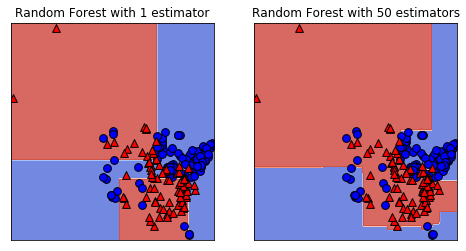

In [168]:
# Let's examine how the decision boundaries change with the number of estimators

rf_1 = RandomForestClassifier(n_estimators=1, max_depth=3)
rf_1.fit(X_train,y_train)


rf_50 = RandomForestClassifier(n_estimators=50, max_depth=3)
rf_50.fit(X_train,y_train)

# Plot Random Forest with 1 estimator
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_classifier(X_train, y_train, rf_1, ax=plt.gca())
plt.title("Random Forest with 1 estimator");

# Plot Random Forest with 50 estimator
plt.subplot(1,2,2)
plot_classifier(X_train, y_train, rf_50, ax=plt.gca())
plt.title("Random Forest with 50 estimators");

In [169]:
def make_num_tree_plot(X_train, y_train, X_test, y_test, num_trees):
    """
    Make number of trees vs error rate plot for RandomForestClassifier
   
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_test: numpy.ndarray        
        The X part of the test/validation set
    y_test: numpy.ndarray
        The y part of the test/validation set    
    num_trees: int
        The value for `n_estimators` argument of RandomForestClassifier
    Returns
    -------
        None
        Shows the number of trees vs error rate plot
            
    """    
    train_err = []
    test_err = []
    for ntree in num_trees:
        model = RandomForestClassifier(n_estimators=ntree)
        model.fit(X_train, y_train)
        train_err.append(1-model.score(X_train, y_train))
        test_err.append(1-model.score(X_test, y_test))

    plt.semilogx(num_trees,train_err,label="train");
    plt.semilogx(num_trees,test_err,label="test");
    plt.legend();
    plt.xlabel('number of trees');
    plt.ylabel('error rate');

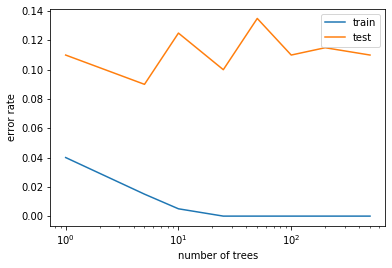

In [170]:
make_num_tree_plot(X_train, y_train, X_test, y_test, (1,5,10,25,50,100,200,500))

#### Number of trees and fundamental trade-off

- Above: seems like we're beating the fundamental "tradeoff" by decreasing training error and not increasing approximation error.
- This is the promise of ensembles, though it's not guaranteed to work so nicely.

### Random forests vs decision trees

- Accuracy
  - Random forests are usually more accurate compared to decision trees, in fact they are usually one of the best performing off-the-shelf classifiers. 
- Speed
  - Slower than decision trees because we are fitting multiple trees 
  - But can easily parallelize training because all trees are independent of each other 
- Overfitting
  - Very deep decision tree tends to overfit 
  - Random forests are less likely to overfit
- Interpretability
  - Decision trees are more interpretable 

## Random forest True/False (10 min)

1. To train a tree in a random forest, we first randomly select a subset of features. The tree is then restricted to only using those features. 
1. A random forest with only one tree would tend to get a higher training error than a decision tree of the same depth.
1. Increasing the hyperparameter `n_estimators` (the number of trees) makes the model more complex and moves the fundamental tradeoff toward lower training error.
1. Increasing the hyperparameter `max_features` (the number of features to consider for a split) makes the model more complex and moves the fundamental tradeoff toward lower training error.



<br><br><br><br><br><br><br><br><br>